In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

### Load Data

In [3]:
visitors_df = pd.read_csv("Visitors.csv")
contacts_df = pd.read_csv("Contacts.csv")

### Sanity check

In [7]:
visitors_df.head()
visitors_df.info()
visitors_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26102 entries, 0 to 26101
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   row_number                          26102 non-null  int64  
 1   visitor_id                          26102 non-null  int64  
 2   search_timestamp                    26102 non-null  object 
 3   category                            26102 non-null  object 
 4   pro_user_id                         26102 non-null  int64  
 5   num_reviews                         26102 non-null  int64  
 6   avg_rating                          24947 non-null  float64
 7   pro_last_active_time_before_search  25035 non-null  object 
 8   cost_estimate_cents                 23944 non-null  float64
 9   result_position                     26102 non-null  int64  
 10  service_page_viewed                 26102 non-null  bool   
dtypes: bool(1), float64(2), int64(5), object(

,row_number,visitor_id,pro_user_id,num_reviews,avg_rating,cost_estimate_cents,result_position
count,26102.000000,2.610200e+04,2.610200e+04,26102.000000,24947.000000,23944.000000,26102.000000
mean,13051.500000,3.424026e+17,2.947009e+17,51.742357,4.666453,11347.352155,7.262930
std,7535.142699,1.530146e+15,5.253396e+16,110.452796,0.432696,4470.170160,6.395579
min,1.000000,3.392089e+17,4.568943e+16,0.000000,1.000000,100.000000,1.000000
25%,6526.250000,3.411617e+17,2.680801e+17,4.000000,4.509615,8900.000000,2.000000
50%,13051.500000,3.428947e+17,3.128504e+17,12.000000,4.790576,10000.000000,5.000000
75%,19576.750000,3.436221e+17,3.357334e+17,44.000000,5.000000,12500.000000,10.000000
max,26102.000000,3.444760e+17,3.443095e+17,997.000000,5.000000,100500.000000,30.000000


In [9]:
# this ensure each visitor only have one search
unique_visitor_count = visitors_df['visitor_id'].drop_duplicates().shape[0]
unique_pair_count = visitors_df[['visitor_id','search_timestamp']].drop_duplicates().shape[0]
unique_visitor_count == unique_pair_count


True

In [11]:
contacts_df.head()
contacts_df.info()
contacts_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   visitor_id   1504 non-null   int64
 1   pro_user_id  1504 non-null   int64
 2   contact_id   1504 non-null   int64
 3   hired        1504 non-null   bool 
dtypes: bool(1), int64(3)
memory usage: 36.8 KB


,visitor_id,pro_user_id,contact_id
count,1.504000e+03,1.504000e+03,1.504000e+03
mean,3.426324e+17,2.827749e+17,3.426334e+17
std,1.473338e+15,5.191436e+16,1.473494e+15
min,3.392089e+17,7.524120e+16,3.392091e+17
25%,3.416098e+17,2.476714e+17,3.416100e+17
50%,3.430898e+17,2.952725e+17,3.430902e+17
75%,3.437850e+17,3.296796e+17,3.437850e+17
max,3.444753e+17,3.438920e+17,3.444755e+17


In [13]:
#this validite the assumption that one visitor may reach out to multiple pros

unique_pairs_count = contacts_df[['visitor_id', 'pro_user_id']].drop_duplicates().shape[0]

unique_visitor_count = contacts_df['visitor_id'].drop_duplicates().shape[0]

print(unique_pairs_count, unique_visitor_count)


1504 1473


### 1st iteration of data maniputation for EDA & Regression

In [16]:
# Timestamps manipulation for time series anysis
visitors_df['date'] = pd.to_datetime(visitors_df['search_timestamp'], utc=True, format='mixed')
visitors_df['pro_last_active_time_before_search'] = pd.to_datetime(visitors_df['pro_last_active_time_before_search'], utc=True, format='mixed')
visitors_df['time_since_pro_active'] = visitors_df['date'] - visitors_df['pro_last_active_time_before_search']
visitors_df['time_since_pro_active_sec'] = visitors_df['time_since_pro_active'].dt.total_seconds() 
visitors_df['search_date'] = visitors_df['date'].dt.strftime('%Y-%m-%d')
visitors_df['search_month'] = visitors_df['date'].dt.month
visitors_df['search_day'] = visitors_df['date'].dt.day
visitors_df['search_hour'] = visitors_df['date'].dt.hour
visitors_df['search_weekday'] = visitors_df['date'].dt.day_name()
print(f"data is availible from {visitors_df['date'].min()} to {visitors_df['date'].max()}.")

data is availible from 2018-10-01 00:40:53.592000+00:00 to 2018-11-30 23:46:21.613000+00:00.


In [453]:
visitors_df

,row_number,visitor_id,search_timestamp,category,pro_user_id,num_reviews,avg_rating,pro_last_active_time_before_search,cost_estimate_cents,result_position,service_page_viewed,date,search_date,search_month,search_day,search_hour,search_weekday
0,15173,344101422347558000,2018-11-26 15:43:43.365 UTC,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,NaN,6,False,2018-11-26 15:43:43.365000+00:00,2018-11-26,11,26,15,Monday
1,8426,344461605879021000,2018-11-30 19:46:46.593 UTC,House Cleaning,344053677817806000,0,NaN,2018-11-29 00:32:46.809 UTC,8900.0,6,False,2018-11-30 19:46:46.593000+00:00,2018-11-30,11,30,19,Friday
2,12809,344142189241475000,2018-11-27 03:03:09.969 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,21,False,2018-11-27 03:03:09.969000+00:00,2018-11-27,11,27,3,Tuesday
3,17310,344215295106097000,2018-11-27 23:21:35.89 UTC,House Cleaning,343931062348177000,0,NaN,NaN,10000.0,22,False,2018-11-27 23:21:35.890000+00:00,2018-11-27,11,27,23,Tuesday
4,10072,344364289304010000,2018-11-29 16:44:50.202 UTC,House Cleaning,343934345272852000,0,NaN,NaN,9000.0,13,False,2018-11-29 16:44:50.202000+00:00,2018-11-29,11,29,16,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26097,17765,344404210763063000,2018-11-30 03:50:11.345 UTC,Local Moving (under 50 miles),272345585989305000,249,4.493976,2018-11-30 03:43:54.951 UTC,7400.0,1,False,2018-11-30 03:50:11.345000+00:00,2018-11-30,11,30,3,Friday
26098,14259,343277153447100000,2018-11-17 02:45:54.125 UTC,House Cleaning,258980375474922000,251,4.693227,2018-11-17 01:34:10.596 UTC,7500.0,1,False,2018-11-17 02:45:54.125000+00:00,2018-11-17,11,17,2,Saturday
26099,1490,343087749834981000,2018-11-14 22:09:10.472 UTC,Local Moving (under 50 miles),216681723444741000,254,4.661417,2018-11-14 20:32:17.354 UTC,8000.0,1,False,2018-11-14 22:09:10.472000+00:00,2018-11-14,11,14,22,Wednesday
26100,4087,343081700706951000,2018-11-14 20:28:21.285 UTC,Local Moving (under 50 miles),216681723444741000,254,4.661417,2018-11-14 20:10:00.722 UTC,8000.0,1,False,2018-11-14 20:28:21.285000+00:00,2018-11-14,11,14,20,Wednesday


In [20]:
# Merge visitors and contacts datasets to analyze pro attributes leading to customer interest
merged_df = visitors_df.merge(contacts_df, on=['visitor_id', 'pro_user_id'], how='left')
merged_df['contacted'] = merged_df['contact_id'].notna()
merged_df['hired'] = merged_df['hired'].fillna(False)


/var/folders/bn/nbxzlnl900v1fcwzqvrf7gmc0000gn/T/ipykernel_50854/1591160316.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['hired'] = merged_df['hired'].fillna(False)


 ### Data Exploration(Quantity)

#### Quantity of search results --- how many results were shown each search?

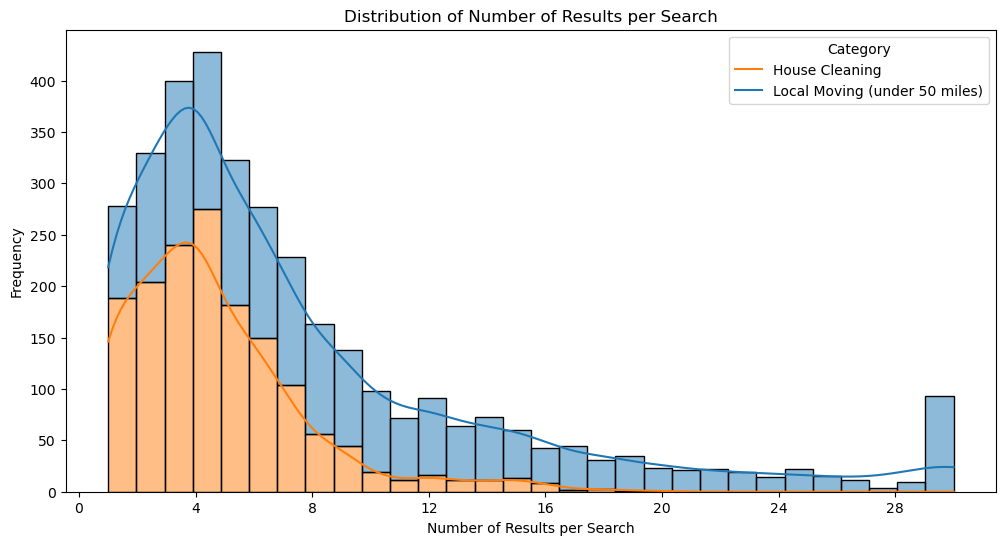

In [630]:
search_counts = visitors_df.groupby(['visitor_id',  'category'])['pro_user_id'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.histplot(data=search_counts, x='pro_user_id', hue='category', kde=True, bins=30, multiple="stack")
plt.xlabel("Number of Results per Search")
plt.ylabel("Frequency")
plt.xticks(ticks=range(0,30,4))
plt.title("Distribution of Number of Results per Search")
plt.legend(title="Category",labels=search_counts['category'].unique())
plt.savefig("Distribution of Number of Pros Listed per Search.png", dpi=300, bbox_inches='tight')
plt.show()


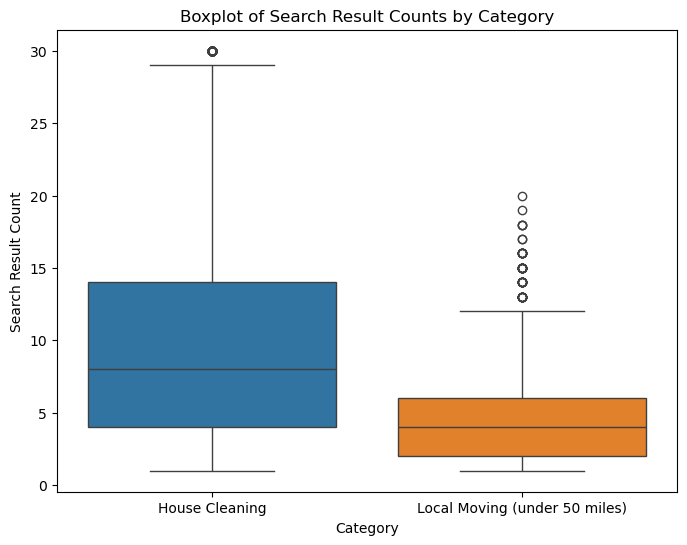

In [632]:
# Plot boxplot with category as hue
plt.figure(figsize=(8, 6))
sns.boxplot(x="category", y="pro_user_id", hue="category", data=search_counts)

plt.title("Boxplot of Search Result Counts by Category")
plt.xlabel("Category")
plt.ylabel("Search Result Count")
plt.savefig("Boxplot of Search Result Counts by Category", dpi=300, bbox_inches='tight')
plt.show()

In [506]:
search_result_summary = search_counts["pro_user_id"].describe()
search_result_summary

count    3428.000000
mean        7.614352
std         6.710100
min         1.000000
25%         3.000000
50%         5.000000
75%        10.000000
max        30.000000
Name: pro_user_id, dtype: float64

#### Quantity of search result --- how many search by day?

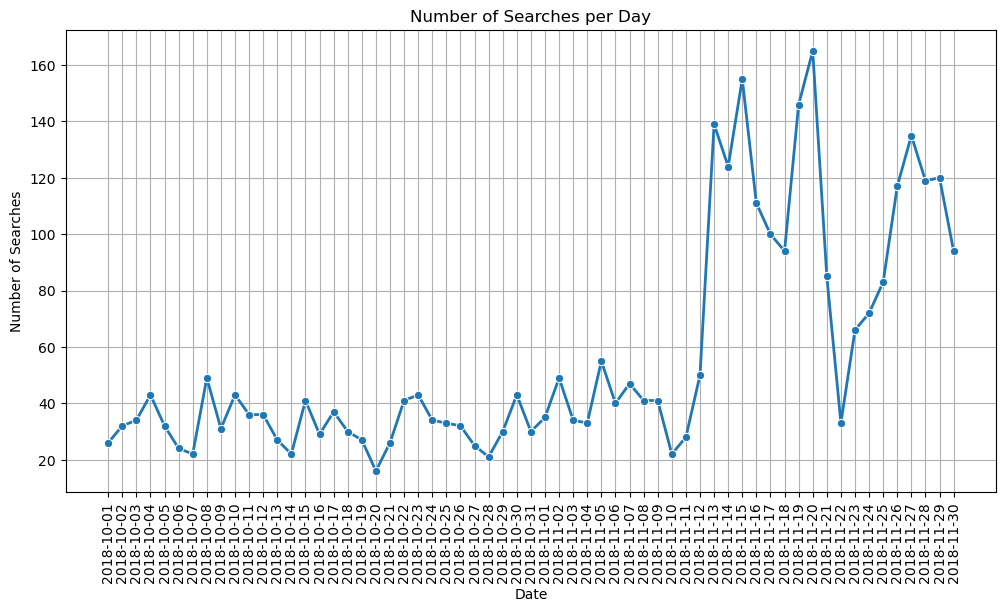

In [634]:
# Count searches per day
searches_per_day = visitors_df.groupby('search_date')['visitor_id'].nunique().reset_index(name='num_searches')

plt.figure(figsize=(12, 6))
sns.lineplot(data=searches_per_day, x='search_date', y='num_searches', marker='o', linewidth=2)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of Searches")
plt.title("Number of Searches per Day")
plt.grid(True)
plt.savefig("Number of Searches per Day", dpi=300, bbox_inches='tight')
plt.show()

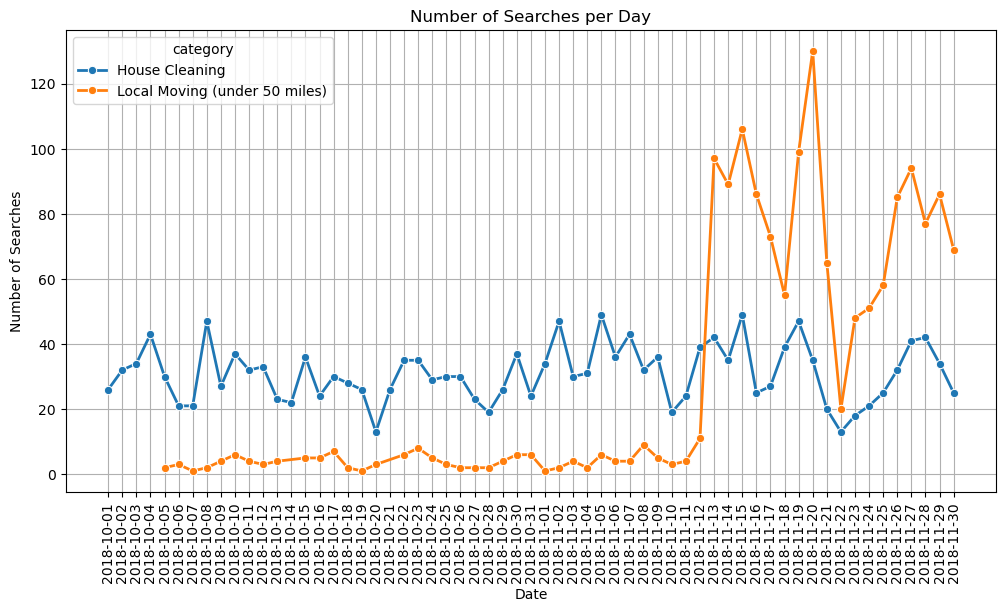

In [636]:
searches_per_day_per_cat = visitors_df.groupby(['search_date','category'])['visitor_id'].nunique().reset_index(name='num_searches')

plt.figure(figsize=(12, 6))
sns.lineplot(data=searches_per_day_per_cat, x='search_date', y='num_searches', marker='o',  hue='category', linewidth=2)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of Searches")
plt.title("Number of Searches per Day")
plt.grid(True)
plt.savefig("Number of Searches per Day by cat", dpi=300, bbox_inches='tight')
plt.show()


#### Quantity of search result --- how many search by weekday and hour?

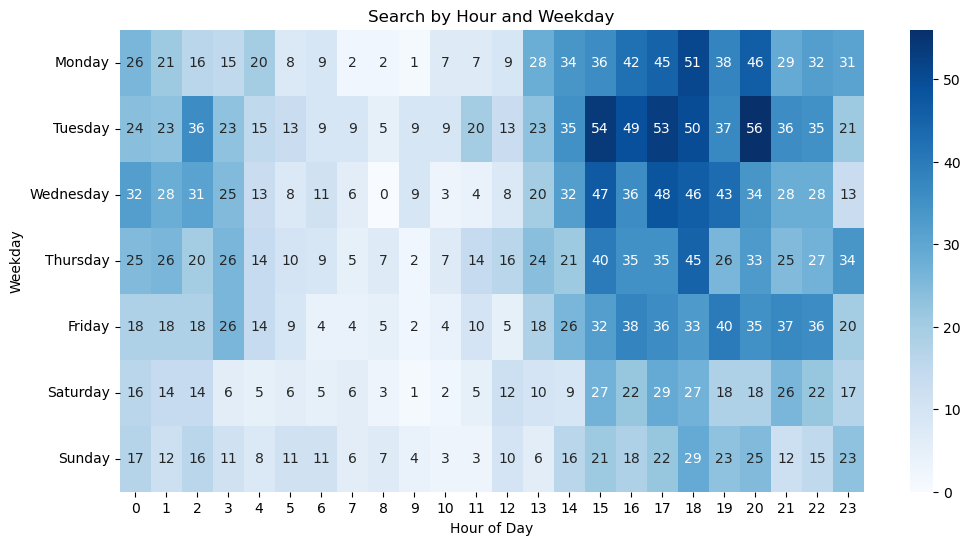

In [638]:
heatmap_data = visitors_df.pivot_table(index='search_weekday', columns='search_hour', values='visitor_id', aggfunc=pd.Series.nunique, fill_value=0)

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(weekday_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt="d")
plt.title("Search by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.savefig("Search by Hour and Weekday", dpi=300, bbox_inches='tight')
plt.show()

### Quantity of search result --- how many result were returned per search by day?

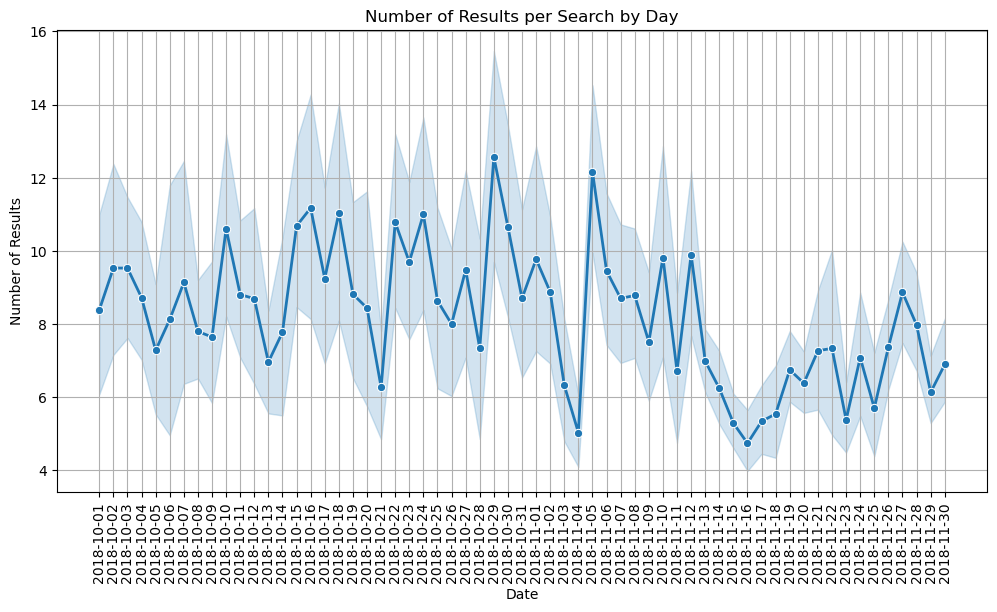

In [355]:
# Count searches per day
results_per_search_per_day = visitors_df.groupby(['search_date','visitor_id'])['pro_user_id'].count().reset_index(name='num_results')

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_per_search_per_day, x='search_date', y='num_results', marker='o' ,linewidth=2)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of Results")
plt.title("Number of Results per Search by Day")
plt.grid(True)
plt.show()

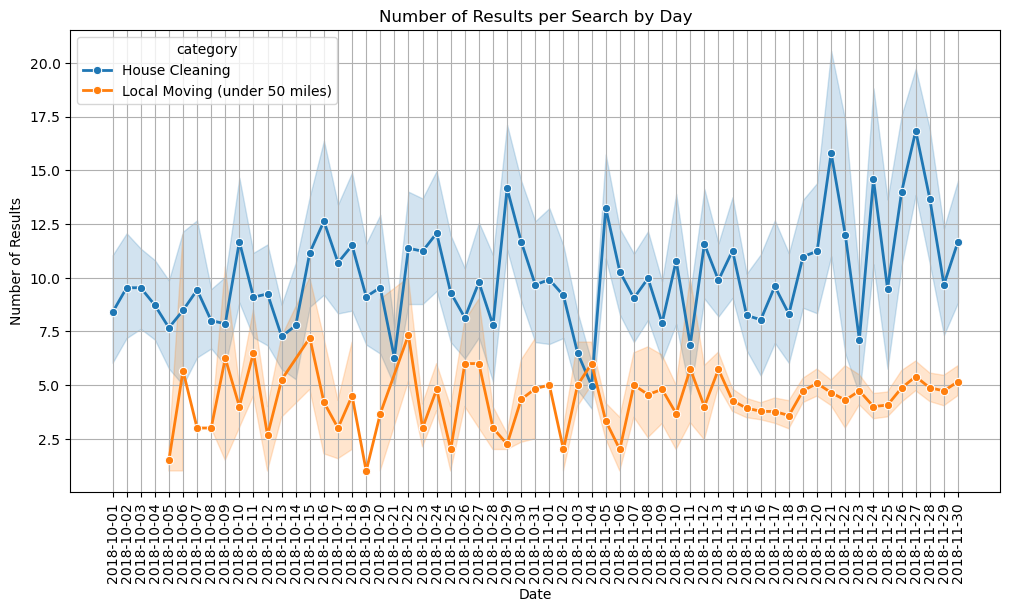

In [640]:
# Count searches per day
results_per_search_per_day_by_cat = visitors_df.groupby(['search_date','visitor_id','category'])['pro_user_id'].count().reset_index(name='num_results')

plt.figure(figsize=(12, 6))
sns.lineplot(data=results_per_search_per_day_by_cat, x='search_date', y='num_results', marker='o', hue= 'category' ,linewidth=2)
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Number of Results")
plt.title("Number of Results per Search by Day")
plt.grid(True)
plt.savefig("Number of Results per Search by Day", dpi=300, bbox_inches='tight')
plt.show()


 ### Data Exploration(Quality)

#### Quality of search result -- how ranking system perform?

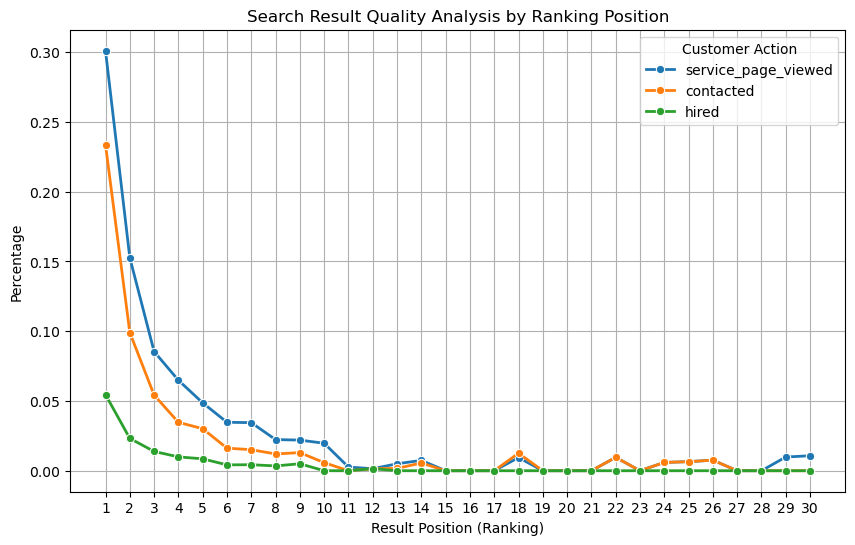

In [668]:
# Analyze search result quality based on ranking position and customer actions
search_quality_analysis = merged_df.groupby('result_position').agg({
    'service_page_viewed': 'mean',  # Percentage of times a pro's page was viewed
    'contacted': 'mean',  # Percentage of times a pro was contacted
    'hired': 'mean'  # Percentage of times a pro was hired
}).reset_index()

search_quality_melted = search_quality_analysis.melt(id_vars="result_position", var_name="Metric", value_name="Percentage")

# Plot the search quality analysis using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=search_quality_melted, x='result_position', y='Percentage', hue='Metric', marker='o', linewidth=2)

plt.xlabel("Result Position (Ranking)")
plt.ylabel("Percentage")
plt.title("Search Result Quality Analysis by Ranking Position")
plt.xticks(range(1, search_quality_analysis['result_position'].max() + 1))
plt.grid(True)
plt.legend(title="Customer Action")
plt.savefig("Search Result Quality Analysis by Ranking Position", dpi=300, bbox_inches='tight')

plt.show()

## Pro Attributes analysis

In [646]:
pro_attributes_analysis = merged_df.groupby('hired').agg({
    'num_reviews': ['mean', 'median'],
    'avg_rating': ['mean', 'median'],
    'cost_estimate_cents': ['mean', 'median'],
    'result_position': ['mean', 'median']
}).reset_index()

pro_attributes_analysis

hired num_reviews        avg_rating           cost_estimate_cents           \
                mean median       mean    median                mean   median   
0  False   50.831423   12.0   4.665567  4.791946        11370.206365  10000.0   
1   True  116.333333   45.0   4.727139  4.769231         9784.057971   9000.0   

  result_position         
             mean median  
0        7.334123    5.0  
1        2.214876    1.0

### 2nd iterration for Data imputation for PCA and Regression

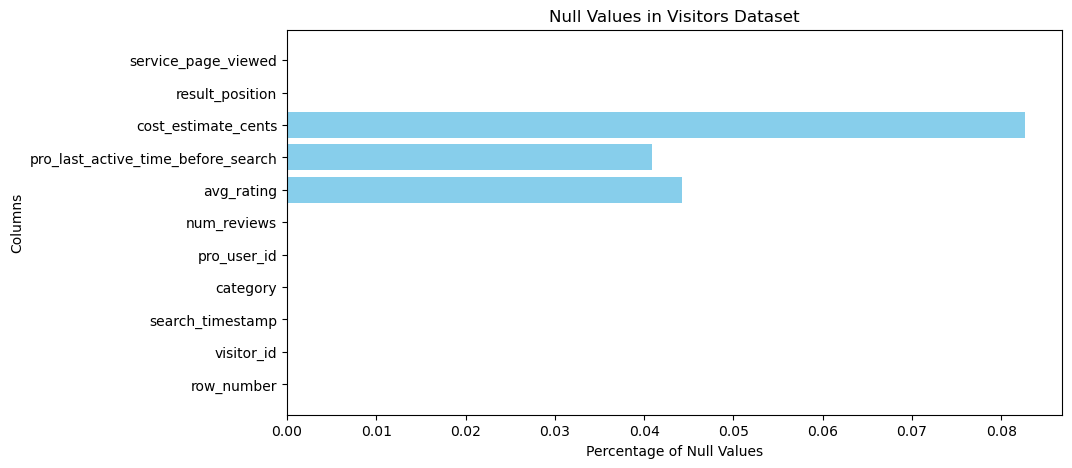

In [670]:
#### Missing value imputation
visitors_df1 = pd.read_csv("Visitors.csv")
visitors_null_pct = visitors_df1.isnull().mean() 


# Plot null value percentages for Visitors dataset
plt.figure(figsize=(10, 5))
plt.barh(visitors_null_pct.index, visitors_null_pct, color='skyblue')
plt.xlabel("Percentage of Null Values")
plt.ylabel("Columns")
plt.title("Null Values in Visitors Dataset")
plt.savefig("Null Values in Visitors Dataset", dpi=300, bbox_inches='tight')
plt.show()

# Display null percentages as dataframes
visitors_null_df = visitors_null_pct.to_frame(name="Null Percentage")

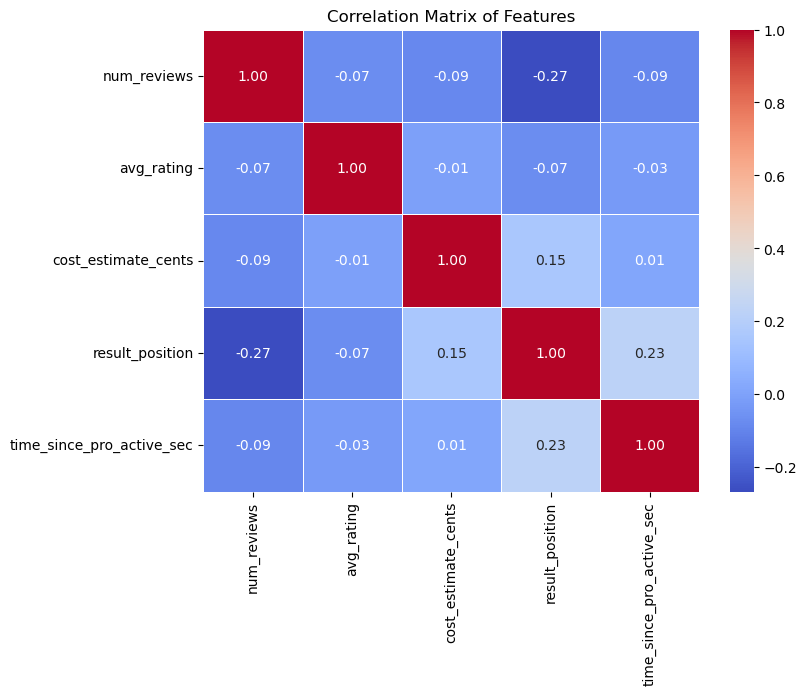

In [63]:
corr_matrix = merged_df[features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")

plt.show()


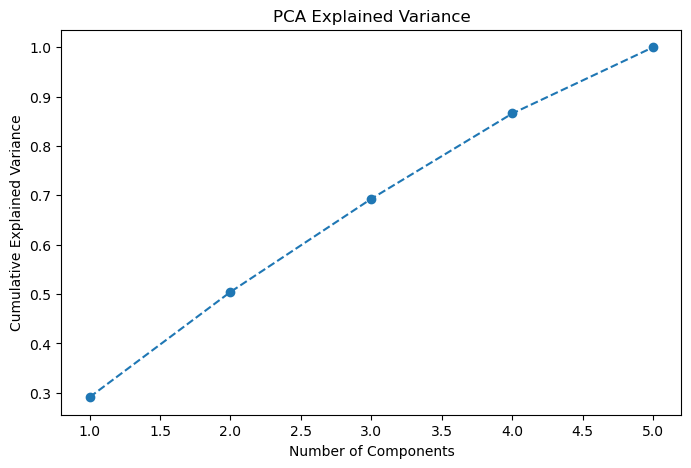

In [65]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_df[features].fillna(0))

# Fit PCA
pca = PCA(n_components=len(features))
pca.fit(X_scaled)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(features) + 1), np.cumsum(pca.explained_variance_ratio_), marker="o", linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.savefig("PCA Explained Variance", dpi=300, bbox_inches='tight')
plt.show()

In [658]:
features = ['num_reviews', 'avg_rating', 'cost_estimate_cents', 'result_position','time_since_pro_active_sec']



X = merged_df[features].fillna(merged_df[features].mode().iloc[0])  # Handle missing values
y = merged_df['hired']

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression model with p-values
import statsmodels.api as sm

# Add constant for intercept in statsmodels
X_const = sm.add_constant(X_scaled)

# Fit logistic regression model using statsmodels
logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

# Extract coefficients and p-values
feature_importance = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': result.params,
    'P-Value': result.pvalues
}).sort_values(by="Coefficient", ascending=False)

feature_importance 

Optimization terminated successfully.
         Current function value: 0.063794
         Iterations 11


,Feature,Coefficient,P-Value
x2,avg_rating,0.151851,6.287848e-02
x1,num_reviews,0.084636,1.297050e-02
x5,time_since_pro_active_sec,0.004325,9.671354e-01
x3,cost_estimate_cents,-0.238386,2.613645e-03
x4,result_position,-2.780193,1.837297e-37
const,Intercept,-5.910490,3.249530e-253


/var/folders/bn/nbxzlnl900v1fcwzqvrf7gmc0000gn/T/ipykernel_95236/2375449939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
/var/folders/bn/nbxzlnl900v1fcwzqvrf7gmc0000gn/T/ipykernel_95236/2375449939.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_sorted, x="Coefficient", y="Feature", palette="coolwarm")


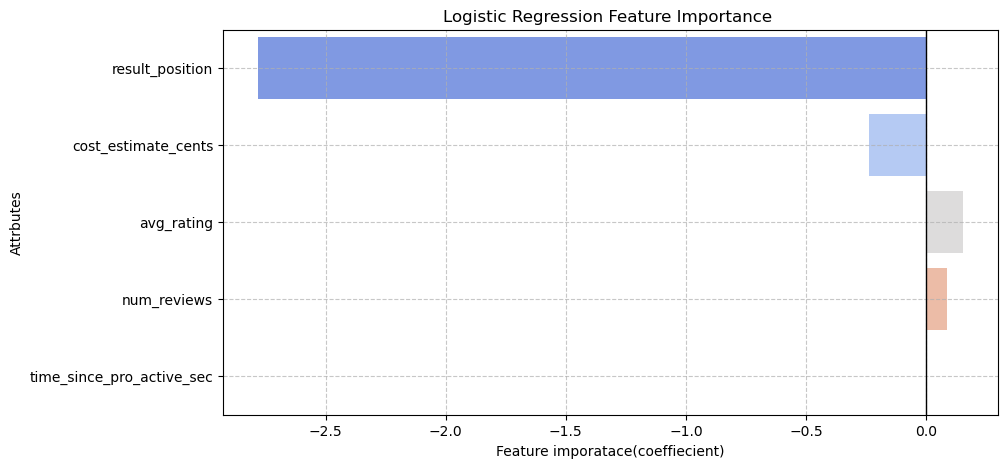

In [662]:

feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
feature_importance= feature_importance[feature_importance["Feature"] != "Intercept"]
feature_importance_sorted = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)

# Plot Coefficients ordered by absolute values
plt.figure(figsize=(10, 5))
sns.barplot(data=feature_importance_sorted, x="Coefficient", y="Feature", palette="coolwarm")
plt.axvline(0, color='black', linewidth=1)  # Reference line at 0
plt.xlabel("Feature imporatace(coeffiecient)")
plt.ylabel("Attrbutes")
plt.title("Logistic Regression Feature Importance ")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("Logistic Regression Feature Importance", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/bn/nbxzlnl900v1fcwzqvrf7gmc0000gn/T/ipykernel_50854/3165615241.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=xgb_feature_importance, palette="Blues")


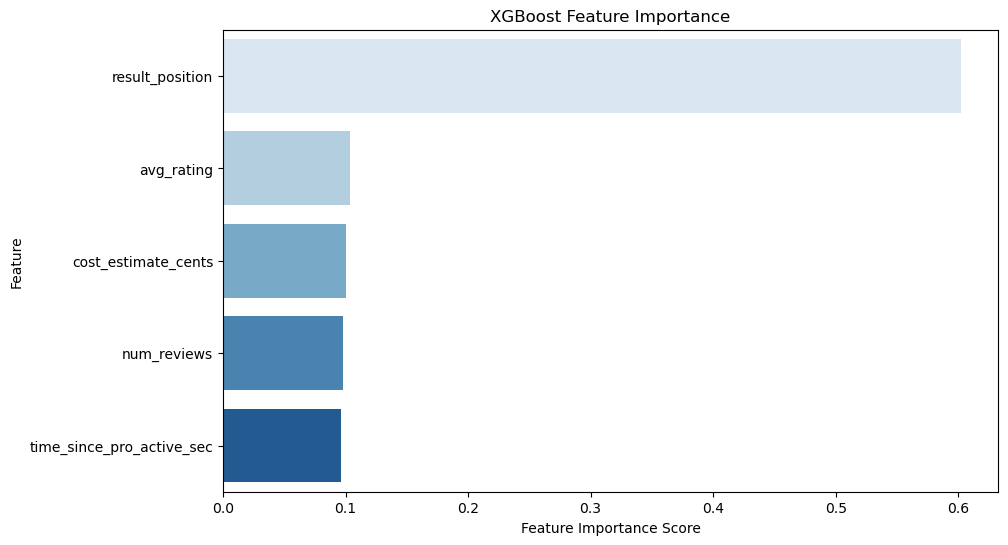

In [35]:


features = ['num_reviews', 'avg_rating', 'cost_estimate_cents', 'result_position', 'time_since_pro_active_sec']
X = merged_df[features].fillna(0)  # Handle missing values
y = merged_df['hired']

shap_explainer = shap.TreeExplainer(xgb_model)
shap_values = shap_explainer.shap_values(X.sample(n=500, random_state=42))

# Create SHAP Beeswarm plot
plt.figure()
shap.summary_plot(shap_values, X.iloc[:500])

# Save the beeswarm plot as PNG
plt.savefig("shap_beeswarm.png", dpi=300, bbox_inches="tight")

# Save as PDF (optional)
plt.savefig("shap_beeswarm.pdf", bbox_inches="tight")

# Close the plot to free memory
plt.close()

print("SHAP Beeswarm plot saved as 'shap_beeswarm.png' and 'shap_beeswarm.pdf'.") = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X, y)

# Get feature importance
xgb_importance = xgb_model.feature_importances_

# Convert to DataFrame
xgb_feature_importance = pd.DataFrame({'Feature': features, 'Importance': xgb_importance})
xgb_feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=xgb_feature_importance, palette="Blues")
plt.title("XGBoost Feature Importance")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()


In [71]:


shap_explainer = shap.TreeExplainer(xgb_model)
shap_values = shap_explainer.shap_values(X)


print("SHAP values shape:", shap_values.shape)

shap.summary_plot(shap_values, X,show=False)

# Save the plot
plt.savefig("shap_beeswarm_fixed.png", dpi=300, bbox_inches="tight")
plt.close()
print("SHAP Beeswarm plot saved successfully!")

SHAP values shape: (26102, 5)
SHAP Beeswarm plot saved successfully!
